# Herschel Stripe 82 master catalogue
## Preparation of SDSS Stripe 82 data

This catalogue comes from `dmu0_SDSS-S82`.

In the catalogue, we keep:

- The `object_id` as unique object identifier;
- The position;
- The u, g, r, i, z, aperture magnitude (for now in 3”);
- The u, g, r, i, z, auto fluxes and magnitudes.


We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates_tiled
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "sdss_ra"
DEC_COL = "sdss_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        "objID": "sdss_id",
        "ra": "sdss_ra",
        "dec": "sdss_dec",
        #"flags": "flags",
        "probPSF": "sdss_stellarity",
        "petroMag_u": "m_sdss_u",
        "petroMag_g": "m_sdss_g",
        "petroMag_r": "m_sdss_r",
        "petroMag_i": "m_sdss_i",
        "petroMag_z": "m_sdss_z",
        "petroMagErr_u": "merr_sdss_u",
        "petroMagErr_g": "merr_sdss_g",
        "petroMagErr_r": "merr_sdss_r",
        "petroMagErr_i": "merr_sdss_i",
        "petroMagErr_z": "merr_sdss_z",
        "fiberMag_u": "m_ap_sdss_u",
        "fiberMag_g": "m_ap_sdss_g",
        "fiberMag_r": "m_ap_sdss_r",
        "fiberMag_i": "m_ap_sdss_i",
        "fiberMag_z": "m_ap_sdss_z",
        "fiberMagErr_u": "merr_ap_sdss_u",
        "fiberMagErr_g": "merr_ap_sdss_g",
        "fiberMagErr_r": "merr_ap_sdss_r",
        "fiberMagErr_i": "merr_ap_sdss_i",
        "fiberMagErr_z": "merr_ap_sdss_z"        
    })


catalogue = Table.read(
    "../../dmu0/dmu0_SDSS-S82/data/SDSS-S82_November2017.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2013

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if 'ap' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        


In [6]:
catalogue[:10].show_in_notebook()

idx,sdss_id,sdss_ra,sdss_dec,sdss_stellarity,m_sdss_u,m_sdss_g,m_sdss_r,m_sdss_i,m_sdss_z,merr_sdss_u,merr_sdss_g,merr_sdss_r,merr_sdss_i,merr_sdss_z,m_ap_sdss_u,m_ap_sdss_g,m_ap_sdss_r,m_ap_sdss_i,m_ap_sdss_z,merr_ap_sdss_u,merr_ap_sdss_g,merr_ap_sdss_r,merr_ap_sdss_i,merr_ap_sdss_z,f_sdss_u,ferr_sdss_u,flag_sdss_u,f_sdss_g,ferr_sdss_g,flag_sdss_g,f_sdss_r,ferr_sdss_r,flag_sdss_r,f_sdss_i,ferr_sdss_i,flag_sdss_i,f_sdss_z,ferr_sdss_z,flag_sdss_z,f_ap_sdss_u,ferr_ap_sdss_u,f_ap_sdss_g,ferr_ap_sdss_g,f_ap_sdss_r,ferr_ap_sdss_r,f_ap_sdss_i,ferr_ap_sdss_i,f_ap_sdss_z,ferr_ap_sdss_z
0,8647474692481943880,0.000131175312639,0.491263499327,0.0,30.5557,23.3423,22.6373,22.0667,22.2511,0.837223,0.126722,0.107992,0.0992946,0.394034,28.8387,23.5877,22.8117,22.4063,22.2319,2.08966,0.0881615,0.0650804,0.0766239,0.213212,0.00217625,0.00167813,False,1.67136,0.195074,False,3.19954,0.318241,False,5.41144,0.494896,False,4.56639,1.65723,False,0.010581,0.0203648,1.33324,0.108259,2.72478,0.163327,3.95796,0.279326,4.64771,0.912697
1,8647475122515542566,0.000134572529402,1.16930309928,0.0,24.0972,22.8681,22.5158,22.3343,22.9333,1.00314,0.126953,0.169153,0.36556,1.35959,24.8363,23.3815,22.946,22.7032,22.6262,0.685327,0.0713973,0.0890261,0.177158,0.363144,0.83394,0.770501,False,2.58687,0.302478,False,3.57832,0.557486,False,4.22955,1.42406,False,2.43603,3.05047,False,0.422151,0.266466,1.61215,0.106014,2.40775,0.197426,3.01093,0.491289,3.23233,1.08111
2,8647474690334460154,0.000137217793067,-1.15889126096,0.0,23.2718,24.3582,23.6434,22.6218,22.2078,0.51123,0.729623,0.484754,0.261689,0.58792,24.4838,24.775,23.8913,23.1932,23.2996,0.467891,0.390163,0.185461,0.158709,0.574816,1.78355,0.8398,False,0.655702,0.440637,False,1.26661,0.56551,False,3.24541,0.782223,False,4.75186,2.5731,False,0.584079,0.251705,0.446665,0.16051,1.00801,0.172183,1.91742,0.280282,1.73838,0.920343
3,8647475119831188340,0.000143891377017,-0.999429714662,0.0,24.3321,24.5065,24.037,23.8087,23.2179,0.712674,0.662726,0.359871,0.479703,0.911372,24.8733,25.4949,24.4754,23.9398,23.3641,0.601305,0.691446,0.283407,0.282288,0.538479,0.671667,0.44088,False,0.571996,0.349142,False,0.881484,0.292171,False,1.08774,0.480586,False,1.87434,1.57333,False,0.408027,0.225975,0.230169,0.146582,0.588652,0.153654,0.964015,0.250641,1.63812,0.812437
4,8647475122515542548,0.000149262470748,1.05950823874,1.0,28.3533,23.7845,22.3685,20.9169,20.1121,5.20651,0.164711,0.0697735,0.0318202,0.0507158,29.9294,24.0111,22.5892,21.1557,20.4105,0.834441,0.117012,0.0494321,0.0230234,0.0381706,0.0165456,0.0793425,False,1.11222,0.168729,False,4.09834,0.263375,False,15.6034,0.457298,False,32.7456,1.52958,False,0.00387478,0.00297796,0.902753,0.0972915,3.34432,0.152262,12.523,0.265555,24.8777,0.874612
5,8647475120368060903,0.000153237080115,-0.498489600971,1.0,27.7477,25.2477,23.8829,22.6544,21.9197,6.58789,0.622332,0.285966,0.161912,0.265881,26.7249,25.3401,24.014,22.93,22.2512,3.02745,0.38542,0.179403,0.109817,0.205364,0.0289012,0.175363,False,0.289009,0.165657,False,1.01589,0.267571,False,3.14947,0.46967,False,6.19619,1.51735,False,0.0741378,0.206725,0.265447,0.0942299,0.900366,0.148773,2.44332,0.247131,4.56564,0.86358
6,8647475120904931573,0.000158245625013,-0.189623468165,0.0,30.5386,23.4604,22.2222,22.0048,23.9817,5.32754,0.806502,0.269944,0.554141,12.6118,25.082,25.3099,23.9131,22.6411,21.9041,0.77352,0.364755,0.168662,0.0825106,0.157201,0.0022108,0.0108481,False,1.49907,1.11353,False,4.68938,1.16591,False,5.72896,2.92396,False,0.927528,10.774,False,0.336677,0.239861,0.272919,0.0916878,0.988033,0.153484,3.18823,0.242289,6.28582,0.910107
7,8647474691945072825,0.000169592060462,0.0739901716782,0.0,22.9756,22.8682,22.4677,21.8399,21.0554,0.485129,0.116024,0.125231,0.111179,0.248974,23.9068,23.6311,23.0321,22.4591,21.8362,0.339988,0.0930743,0.0825857,0.077291,0.201977,2.34297,1.04689,False,2.58644,0.276394,False,3.74028,0.431409,False,6.66863,0.682864,False,13.7354,3.14971,False,0.993771,0.31119,1.28106,0.109819,2.22405,0.169171,

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
import logging
logging.basicConfig(level=logging.INFO)

In [8]:
SORT_COLS = []
FLAG_NAME = 'sdss_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates_tiled(
    catalogue, RA_COL, DEC_COL, 
    sort_col= SORT_COLS,
    flag_name=FLAG_NAME,
    near_ra0=True)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

INFO:herschelhelp_internal.masterlist:The catalogue is divided in 47 x 3 (RA, Dec) tiles
INFO:herschelhelp_internal.masterlist:Processing RA between -9.924922 and -8.924922, and Dec between -1.258481 and -0.258481
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
INFO:herschelhelp_internal.masterlist:Processing RA between -9.924922 and -8.924922, and Dec between -0.258481 and 0.741519
INFO:herschelhelp_internal.masterlist:Processing RA between -9.924922 and -8.924922, and Dec between 0.741519 and 1.741519
INFO:herschelhelp_internal.masterlist:Processing RA between -8.924922 and -7.924922, and Dec between -1.258481 and -0.258481
INFO:herschelhelp_internal.masterlist:Processi

The initial catalogue had 6377638 sources.
The cleaned catalogue has 6376812 sources (826 removed).
The cleaned catalogue has 826 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Herschel-Stripe-82.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

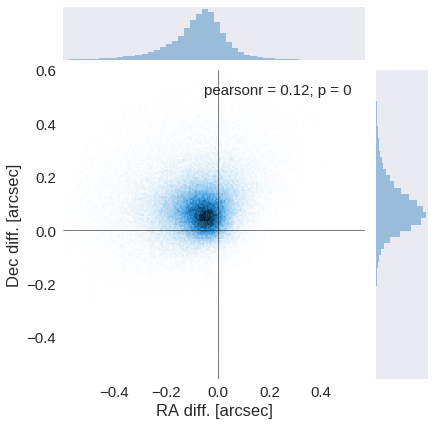

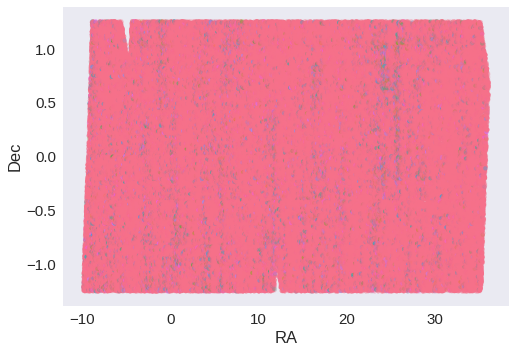

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.06227235712685797 arcsec
Dec correction: -0.0734814464327993 arcsec


In [12]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

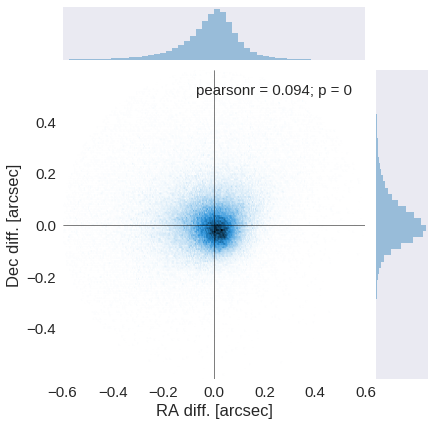

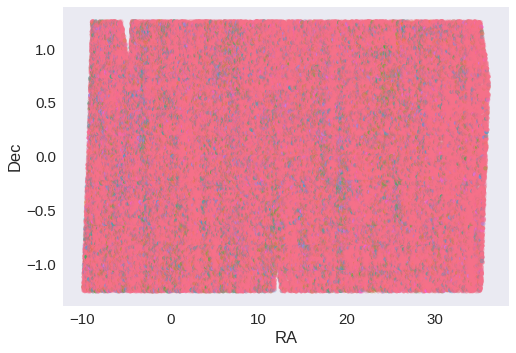

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "sdss_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

232639 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [16]:
catalogue.write("{}/SDSS-S82.fits".format(OUT_DIR), overwrite=True)